# SLAM Unit B - Part 1
In this unit, Unit B, we will learn to use the sensor data to improve the robot's state.
## Localization using *features*
In our first approach, we will use so-called *features*, or *landmarks*, to reason about the *pose* (the position and orientation) of the robot. In our case, the features are the cylinders which are present in our arena and which we detected in Unit A, from the measurements of our laser scanner.

In [19]:
# YouTube = True  # Uncomment this line to get YouTube videos instead of TIB AV.
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/AbmhPu6lgUs" if "YouTube" in globals() else "//av.tib.eu/player/48983",
       width=560, height=315)

### Here is the code which computes the world coordinates for the detected landmarks.

In [20]:
# For each cylinder in the scan, find its cartesian coordinates,
# in the world coordinate system.
# Write the result to a file which contains all cylinders, for all scans.
# 04_a_project_landmarks
from lego_robot import *
from slam_b_library import filter_step, compute_derivative,\
     find_cylinders, compute_cartesian_coordinates

# Put all cylinder extraction and position finding into one function.
def compute_scanner_cylinders(scan, jump, min_dist, cylinder_offset):
    der = compute_derivative(scan, min_dist)
    cylinders = find_cylinders(scan, der, jump, min_dist)
    scanner_cylinders = compute_cartesian_coordinates(cylinders, cylinder_offset)
    return scanner_cylinders

# Utility to write a list of cylinders to (one line of) a given file.
# Line header defines the start of each line, e.g. "D C" for a detected
# cylinder or "W C" for a world cylinder.
def write_cylinders(file_desc, line_header, cylinder_list):
    print(line_header, end=' ', file=file_desc)
    for c in cylinder_list:
        print("%.1f %.1f" % c, end=' ', file=file_desc)
    print(file=file_desc)

if __name__ == '__main__':
    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The constants we used for the cylinder detection in our scan.    
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Iterate over all positions.
    out_file = open("project_landmarks.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Extract cylinders, also convert them to world coordinates.
        cartesian_cylinders = compute_scanner_cylinders(
            logfile.scan_data[i],
            depth_jump, minimum_valid_distance, cylinder_offset)
        world_cylinders = [LegoLogfile.scanner_to_world(pose, c)
                           for c in cartesian_cylinders]

        # Write results to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # The detected cylinders in the scanner's coordinate system.
        write_cylinders(out_file, "D C", cartesian_cylinders)
        # The detected cylinders in the world coordinate system.
        write_cylinders(out_file, "W C", world_cylinders)

    out_file.close()

### Let's have a look at the produced cylinder (world) coordinates.
This reproduces the results shown in the video.

You can see that in the beginning, the detected landmarks, projected to world coordinates, fit reasonably well to the landmarks in the map. However, as the pose of the robot starts to drift away from the true pose, during the first left turn, the landmarks also drift away from their expected (map) location.

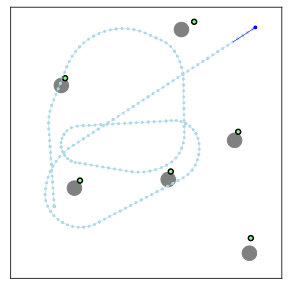

In [21]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["project_landmarks.txt", "robot_arena_landmarks.txt"])

## Assignment of cylinders
In order to use the cylinders for localization, we must first find correspondences between the landmarks we extract from the laser scanner measurements, and the landmarks in our map. This will be our first programming assignment.
### Programming assignment: landmark assignment (15 Points).

In [22]:
# Given a list of cylinders (points) and reference_cylinders:
# For every cylinder, find the closest reference_cylinder and add
# the index pair (i, j), where i is the index of the cylinder, and
# j is the index of the reference_cylinder, to the result list.
import math
import numpy as np

def find_dist(cy0,cy1):
    return math.sqrt(((cy0[0]-cy1[0])**2+(cy0[1]-cy1[1])**2))


def find_cylinder_pairs(cylinders, reference_cylinders, max_radius):
    cylinder_pairs = []

    # Make a loop over all cylinders and reference_cylinders.
    # In the loop, if cylinders[i] is closest to reference_cylinders[j],
    # and their distance is below max_radius, then add the
    # tuple (i,j) to cylinder_pairs, i.e., cylinder_pairs.append( (i,j) ).
    # YOUR CODE HERE
    for i in range (len(cylinders)):
        Distlist=[]
        if len(reference_cylinders)!=0:

            for j in range (len(reference_cylinders)):
            #dist=math.sqrt((cylinders[i][0]-reference_cylinders[j][0])^2+(cylinders[i][1]-reference_cylinders[j][1])^2)
                dist=find_dist(cylinders[i],reference_cylinders[j])
                Distlist.append(dist)
            index_min = np.argmin(Distlist)
            
            if Distlist[index_min]<max_radius:
                cylinder_pairs.append((i,index_min))      

    #raise NotImplementedError()

    return cylinder_pairs

### Let's test some cases.

In [23]:
def public_test(the_find_cylinder_pairs):
    # Test cases: (cylinders, reference, radius, solution).
    test_cases = [
        # Test 0: (1, 1) should match (0, 0) when radius is 2.
        ([(1,1)], [(0,0)], 2, [(0,0)]),

        # Test 1: Three points, not in order: 0, 1, 2 matches 1, 2, 0.
        ([(0,0), (10,0), (10,10)], [(11,9), (1,1), (9,-1)], 2,
         [(0,1), (1,2), (2,0)]),

        # Test 2: If there are several alternatives, take the closest one.
        ([(0,0)], [(1,0), (1,1), (0,5), (10,1), (0.5,0.5), (0,1)], 6, [(0,4)]),

        # Test 3: If all solutions are beyond the radius, the result is empty.
        ([(101,102)], [(0,0), (1,1), (0,2)], 10, []),

        # Test 4, 5, 6, 7: Test that radius is used, not radius squared etc.
        ([(0,0)], [(0, 4.001)], 4, []),
        ([(0,0)], [(0, 3.999)], 4, [(0,0)]),
        ([(1.5,1.5)], [(1,1), (2,2)], 0.7, []), # sqrt(2)/2 = 0.7071 > 0.7.
        ([(1.5,1.5)], [(1,0.999), (2,2)], 0.7072, [(0,1)]),

        # Test 8, 9: If one of the lists is empty, the result is empty.
        ([(0,0), (1,1)], [], 0.1, []),
        ([], [(0,0), (1,1)], 0.1, []),
    ]

    # Run all tests.
    for i, test in enumerate(test_cases):
        try:
            result = the_find_cylinder_pairs(*test[0:3])
            if sorted(result) != sorted(test[3]):
                print("Test number %d failed." % i)
                return False
        except Exception as e:
            print("Test number %d crashed with exception:" % i, repr(e))
            return False
    return True

assert(public_test(find_cylinder_pairs))

In [24]:
find_cylinder_pairs([(0,0), (1,1)], [], 0.1)
#math.sqrt(4.001**2)

[]

### Now we run it and then use the logfile viewer to visually check the assignment results.
This should look like shown in the video. Whenever a landmark was successfully assigned to a measured cylinder, it is marked (by an extra dot in its center).

In [25]:
# For each cylinder in the scan, find its cartesian coordinates,
# in the world coordinate system. Then, find the closest point
# in the reference cylinder dataset and output it.
# 04_b_find_cylinder_pairs
from lego_robot import *
from slam_b_library import filter_step

if __name__ == '__main__':
    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The constants we used for the cylinder detection in our scan.    
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # The maximum distance allowed for cylinder assignment.
    max_cylinder_distance = 300.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Also read the reference cylinders (the map).
    logfile.read("robot_arena_landmarks.txt")
    reference_cylinders = [l[1:3] for l in logfile.landmarks]

    # Iterate over all positions.
    out_file = open("find_cylinder_pairs.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Extract cylinders, also convert them to world coordinates.
        cartesian_cylinders = compute_scanner_cylinders(
            logfile.scan_data[i],
            depth_jump, minimum_valid_distance, cylinder_offset)
        world_cylinders = [LegoLogfile.scanner_to_world(pose, c)
                           for c in cartesian_cylinders]

        # For every cylinder, find the closest reference cylinder.
        cylinder_pairs = find_cylinder_pairs(
            world_cylinders, reference_cylinders, max_cylinder_distance)

        # Write to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # The detected cylinders in the scanner's coordinate system.
        write_cylinders(out_file, "D C", cartesian_cylinders)
        # The reference cylinders which were part of a cylinder pair.
        write_cylinders(out_file, "W C",
            [reference_cylinders[j[1]] for j in cylinder_pairs])

    out_file.close()

In [2]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["find_cylinder_pairs.txt", "robot_arena_landmarks.txt"])

## Estimation of a similarity transform
After we know the correspondences, we can use them to compute a transformation between the measured landmarks and the landmarks in the map. We will use a similarity transform for that. After we have found this transformation, we can align the measured landmarks to the landmarks in the map, and more importantly, we can use it to correct the position and orientation (pose) of the robot.

In [27]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/2Zf7J6cKpOQ" if "YouTube" in globals() else "//av.tib.eu/player/48984",
       width=560, height=315)

###  Programming assignment: using the cylinder pairs, find the transformation (20 Points).

In [28]:
# NOTE: In this notebook you won't have to insert your implementation of find_cylinder_pairs()
#       here, since your function from above is just taken. If this does not work, make sure
#       to execute the cells above.
import numpy as np
# Given a point list, return the center of mass.
def compute_center(point_list):
    # Safeguard against empty list.
    if not point_list:
        return (0.0, 0.0)
    # If not empty, sum up and divide.
    sx = sum([p[0] for p in point_list])
    sy = sum([p[1] for p in point_list])
    return (float(sx) / len(point_list), float(sy) / len(point_list))

# Given a similarity transformation:
# trafo = (scale, cos(angle), sin(angle), x_translation, y_translation)
# and a point p = (x, y), return the transformed point.
def apply_transform(trafo, p):
    la, c, s, tx, ty = trafo
    lac = la * c
    las = la * s
    x = lac * p[0] - las * p[1] + tx
    y = las * p[0] + lac * p[1] + ty
    return (x, y)

# Given a left_list of points and a right_list of points, compute
# the parameters of a similarity transform: scale, rotation, translation.
# If fix_scale is True, use the fixed scale of 1.0.
# The returned value is a tuple of:
# (scale, cos(angle), sin(angle), x_translation, y_translation)
# i.e., the rotation angle is not given in radians, but rather in terms
# of the cosine and sine.
def estimate_transform(left_list, right_list, fix_scale = False):
    # Compute left and right center.
    lc = compute_center(left_list)
    rc = compute_center(right_list)
    
    # if len(left_list) < 2 or len(right_list) < 2:
    #     return None

    # lc = compute_center(left_list)
    # rc = compute_center(right_list)

    # l_i = [tuple(np.subtract(l,lc)) for l in left_list]
    # r_i = [tuple(np.subtract(r,rc)) for r in right_list]

    # cs,ss,rr,ll = 0.0,0.0,0.0,0.0

    # for i in range(len(left_list)):
    #     cs += (r_i[i][0] * l_i[i][0]) + (r_i[i][1] * l_i[i][1])
    #     ss += -(r_i[i][0] * l_i[i][1]) + (r_i[i][1] * l_i[i][0])
    #     rr += (r_i[i][0] * r_i[i][0]) + (r_i[i][1] * r_i[i][1])
    #     ll += (l_i[i][0] * l_i[i][0]) + (l_i[i][1] * l_i[i][1])

    # if fix_scale:
    #     la = 1.0
    # else:
    #     la = sqrt(rr/ll)
    # if cs==0 and ss==0:
    #     return None
    # else:    
    #     c = cs / sqrt((cs*cs) + (ss*ss))
    #     s = ss / sqrt((cs*cs) + (ss*ss))

    # tx = rc[0] - (la * ((c * lc[0]) - (s * lc[1])))
    # ty = rc[1] - (la * ((s * lc[0]) + (c * lc[1])))

    # Needs to compute: lambda, c, s, and tx, ty, where c and s are
    # the cosine and sine of the rotation angle, i.e. (c, s) is a
    # unit vector indicating the rotation (i.e. where the x-axis
    # points to after rotation).
    # YOUR CODE HERE
    l_p=[]
    r_p=[]
    for i in range (len(left_list)):

        # l_p.append(np.diff([left_list[i],lc]))
        # r_p.append(np.diff([right_list[i],rc])) np.diff rechnet nur die absolute Differenz, stattdessen
        # sollte die Substraktion eingeführt werden
        l_p = [tuple(np.subtract(l,lc)) for l in left_list]
        r_p = [tuple(np.subtract(r,rc)) for r in right_list]

    cs, ss, rr, ll=0.0,0.0,0.0,0.0
    for i in range (len(left_list)):

        cs+=l_p[i][0]*r_p[i][0]+r_p[i][1]*l_p[i][1]
        ss+=-r_p[i][0]*l_p[i][1]+r_p[i][1]*l_p[i][0]
        rr+=r_p[i][0]**2+r_p[i][1]**2
        ll+=l_p[i][0]**2+l_p[i][1]**2

    if fix_scale:
        la = 1.0
    else:
        la = sqrt(rr/ll)
    if cs==0 and ss==0:
        return None
    else:    

    # if cs==0 or ss==0:
    #     return None
    # else:    
        c=cs/math.sqrt(cs**2+ss**2)
        s=ss/math.sqrt(cs**2+ss**2)

    tx=rc[0]-la*(c*lc[0]-s*lc[1])
    ty=rc[1]-la*(s*lc[0]+c*lc[1])


    #raise NotImplementedError()
    return la, c, s, tx, ty

### Let's test this.
Note that if you get test errors like *division by zero*, it may be the case that your code does not handle singular cases well. You may also get hints from the SLAM B 03 video below how to handle those cases properly.

In [1]:
d=estimate_transform([(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         [(0.1,0.0), (1.0,0.1), (0.1, 1.0)],
         False)
print(d)

NameError: name 'estimate_transform' is not defined

In [ ]:
from math import sqrt

# A non-numpy parameter comparison function which tolerates small errors.
def similar_transform_parameters(trafo_a, trafo_b):
    if trafo_a == None or trafo_b == None:
        return trafo_a == trafo_b
    return len(trafo_a)== 5 and len(trafo_b)==5 and\
           max(abs(a-b) for (a,b) in zip(trafo_a, trafo_b)) < 0.0001

# The test function.
def public_test(the_estimate_transform):
    # test_cases is a list of tuples. Each tuple is:
    # (left_list, right_list, fix_scale, error text).
    test_cases = [
        # Test 0: 3 points which are perfectly aligned, no fixed scale.
        ([(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         [(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         False, (1.0, 1.0, 0.0, 0.0, 0.0)),
        
        # Test 1: 3 points which are perfectly aligned, w/ fixed scale.
        ([(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         [(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         True, (1.0, 1.0, 0.0, 0.0, 0.0)),
        
        # Test 2: 3 points, almost aligned, no fixed scale.
        ([(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         [(0.1,0.0), (1.0,0.1), (0.1, 1.0)],
         False, (0.9273618495495702, 0.9996349698728535, 0.02701716134791493,
                 0.09934378339382115, 0.049307326915700056)),
        
        # Test 3: 3 points, almost aligned, w/ fixed scale.
        ([(0.0,0.0), (1.0,0.0), (0.0, 1.0)],
         [(0.1,0.0), (1.0,0.1), (0.1, 1.0)],
         True, (1.0, 0.9996349698728535, 0.02701716134791493,
                0.07579406382502057, 0.02444928959307724)),

        # Test 4, 5: 2 points still work.
        ([(0.0,0.0), (1.0,1.0),],
         [(0.0,0.0), (1.1,1.1)],
         False, (1.1, 1.0, 0.0, 0.0, 0.0)),
        ([(0.0,0.0), (1.0,1.0),],
         [(0.0,0.0), (1.1,1.1)],
         True, (1.0, 1.0, 0.0, 0.05, 0.05)),

        # Test 6: 1 point always fails, because the transform cannot be
        # estimated from a single point. Your code shouldn't crash.
        ([(123.0, 234.0)],
         [(234.0, 345.0)],
         True, None),

        # Test 7, 8: all identical points also fails, because the transform
        # cannot be estimated from a single point. Your code shouldn't crash.
        ([(123.0, 234.0), (123.0, 234.0), (123.0, 234.0)],
         [(0.0,0.0), (1.1,1.1), (2.2,2.2)],
         True, None),
        ([(0.0,0.0), (1.1,1.1), (2.2,2.2)],
         [(123.0, 234.0), (123.0, 234.0), (123.0, 234.0)],
         True, None),
    ]

    for i, test in enumerate(test_cases):
        l, r, fix, ref_result = test
        try:
            result = the_estimate_transform(l, r, fix)
            if not similar_transform_parameters(result, ref_result):
                print("Test number %d failed." % i)
                return False
        except Exception as e:
            print("Test number %d crashed with exception:" % i, repr(e))
            return False
    return True

assert(public_test(estimate_transform))

Now that you have implemented `estimate_transform`, you can run the following cell to produce the file `estimate_transform.txt` which we will look at below.

In [ ]:
# For each cylinder in the scan, find its cartesian coordinates,
# in the world coordinate system.
# Find the closest pairs of cylinders from the scanner and cylinders
# from the reference, and the optimal transformation which aligns them.
# Then, output the scanned cylinders, using this transform.
# 04_c_estimate_transform
from lego_robot import *
from slam_b_library import filter_step, compute_scanner_cylinders,\
    write_cylinders

# NOTE: In this notebook you won't have to insert your implementation of find_cylinder_pairs()
#       here, since your function from above is just taken. If this does not work, make sure
#       to execute the cells above.

if __name__ == '__main__':
    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The constants we used for the cylinder detection in our scan.    
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # The maximum distance allowed for cylinder assignment.
    max_cylinder_distance = 300.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Also read the reference cylinders (this is our map).
    logfile.read("robot_arena_landmarks.txt")
    reference_cylinders = [l[1:3] for l in logfile.landmarks]

    out_file = open("estimate_transform.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Extract cylinders, also convert them to world coordinates.
        cartesian_cylinders = compute_scanner_cylinders(
            logfile.scan_data[i],
            depth_jump, minimum_valid_distance, cylinder_offset)
        world_cylinders = [LegoLogfile.scanner_to_world(pose, c)
                           for c in cartesian_cylinders]

        # For every cylinder, find the closest reference cylinder.
        cylinder_pairs = find_cylinder_pairs(
            world_cylinders, reference_cylinders, max_cylinder_distance)

        # Estimate a transformation using the cylinder pairs.
        trafo = estimate_transform(
            [world_cylinders[pair[0]] for pair in cylinder_pairs],
            [reference_cylinders[pair[1]] for pair in cylinder_pairs],
            fix_scale = True)

        # Transform the cylinders using the estimated transform.
        transformed_world_cylinders = []
        if trafo:
            transformed_world_cylinders =\
                [apply_transform(trafo, c) for c in
                 [world_cylinders[pair[0]] for pair in cylinder_pairs]]            

        # Write to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # The detected cylinders in the scanner's coordinate system.
        write_cylinders(out_file, "D C", cartesian_cylinders)
        # The detected cylinders, transformed using the estimated trafo.
        write_cylinders(out_file, "W C", transformed_world_cylinders)

    out_file.close()

## Pose correction from measurement data
In this section, we will use the estimated transform to correct the pose of our robot. This is our first step towards using measurement data to estimate the state of the robot.

In [ ]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/zSUoE-I9kkc" if "YouTube" in globals() else "//av.tib.eu/player/48985",
       width=560, height=315)

### First, as in the video, let's look at the results of the similarity transform estimation.
The *assigned landmarks* are marked again, but this time, in a different way!

*Previously,* every landmark in the map that was used in an assignment was marked by an extra dot in its center. Even if only one landmark could be assigned, this single landmark was marked (e.g., check above the robot position (step) 63, where only a single landmark is assigned).

*Now,* the best transform of the measured landmarks to the map landmarks is computed and applied. So the dots are not in the center of the map landmarks anymore, but rather close to them $-$ as close as possible, in the least squares sense. Also, if less than two landmarks are assigned, the transformation will not be performed and no dots will appear (again, check robot position 63).

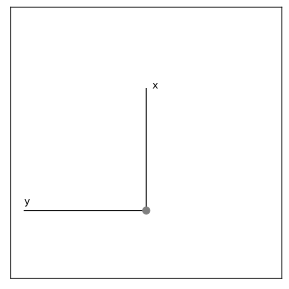

In [ ]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["estimate_transform.txt", "robot_arena_landmarks.txt"])

### Next, we correct the pose, in the following assignment (10 Points).
As shown in the above video, all there is to do is to implement the `correct_pose(pose, trafo)` function.

In [ ]:
# NOTE: In this notebook you won't have to insert your implementation of previous functions
#       here, since your functions from above are just taken. If this does not work, make sure
#       to execute the cells above.

# Correct the pose = (x, y, heading) of the robot using the given
# similarity transform. Note this changes the position as well as
# the heading.
def correct_pose(pose, trafo):
    # YOUR CODE HERE

    # die Transformation der Pose des Fahrzeugs ist nichts anders als die Landmarke, jede Abtastzeit haben sich die Rotationsparameter durch die left_list und right_list
    # vollständig bestimmt, durch die Einsetzung in Korrekturfunktion ist die Position des Fahrzeugs auch zu filtern. Die Orientierungswinkel halten die Regel ein, dass die 
    # durch die Rotationswinkel alpha im gegenuhrzeiger Sinn zu addieren, um die neue Richtung zu korrigieren.
    la, c, s, tx, ty =trafo
    x, y ,t=pose
    #raise NotImplementedError()
    [x,y]=apply_transform(trafo, (x,y))
    t=t+atan2(s,c)
    
    return (x, y, t)

### First, let's test your implementation.

In [ ]:
from random import random
from math import sin, cos, atan2, pi
def public_test(the_correct_pose):
    number_of_tests = 10
    for test in range(number_of_tests):
        # Choose a random robot position, in polar coordinates:
        # vector lenght and angle.
        old_len, old_phi = random()*5, random()*2*pi
        # Also choose a random robot heading.
        old_heading = random()*2*pi
        # From this, define the old pose in Euclidean coordinates.
        old_pose = (old_len*cos(old_phi), old_len*sin(old_phi), old_heading)

        # Choose a random transformation.
        trf_angle = random()*2*pi
        trf_scale, trf_x, trf_y = random()+0.5, random()*4-2, random()*6-3
        # Convert to our 5-element tuple specification of a trafo.
        trf = (trf_scale, cos(trf_angle), sin(trf_angle), trf_x, trf_y)

        # Compute the new pose, using polar coordinates.
        new_len = old_len * trf_scale
        new_phi = old_phi + trf_angle
        # From this, define the new pose in Euclidean coordinates.
        new_pose = (new_len*cos(new_phi)+trf_x, new_len*sin(new_phi)+trf_y,
                    old_heading+trf_angle)

        # Now we are ready to run the function to be tested.
        # Note for heading, we test cos and sin to prevent mod 2pi ambiguities.
        try:
            pose = the_correct_pose(old_pose, trf)
            if abs(new_pose[0]-pose[0]) > 0.0001 or\
               abs(new_pose[1]-pose[1]) > 0.0001 or\
               abs(cos(new_pose[2])-cos(pose[2])) > 0.0001 or\
               abs(sin(new_pose[2])-sin(pose[2])) > 0.0001:
                print("Produced the wrong result for:")
                print("Initial pose:", old_pose)
                print("Transformation:", trf)
                print("Expected result:", new_pose)
                print("Your result:", pose)
                return False
        except Exception as e:
            print("Your code crashed with exception:", repr(e))
            return False
    return True
assert(public_test(correct_pose))

After the test works, run the following cell to produce the file `apply_transform.txt` which we will look at below.

In [ ]:
# For each cylinder in the scan, find its cartesian coordinates,
# in the world coordinate system.
# Find the closest pairs of cylinders from the scanner and cylinders
# from the reference, and the optimal transformation which aligns them.
# Then, use this transform to correct the pose.
# 04_d_apply_transform
from lego_robot import *
from slam_b_library import filter_step, compute_scanner_cylinders,\
    write_cylinders
from math import sqrt, atan2

if __name__ == '__main__':
    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The constants we used for the cylinder detection in our scan.    
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # The maximum distance allowed for cylinder assignment.
    max_cylinder_distance = 400.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Also read the reference cylinders (this is our map).
    logfile.read("robot_arena_landmarks.txt")
    reference_cylinders = [l[1:3] for l in logfile.landmarks]

    out_file = open("apply_transform.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Extract cylinders, also convert them to world coordinates.
        cartesian_cylinders = compute_scanner_cylinders(
            logfile.scan_data[i],
            depth_jump, minimum_valid_distance, cylinder_offset)
        world_cylinders = [LegoLogfile.scanner_to_world(pose, c)
                           for c in cartesian_cylinders]

        # For every cylinder, find the closest reference cylinder.
        cylinder_pairs = find_cylinder_pairs(
            world_cylinders, reference_cylinders, max_cylinder_distance)

        # Estimate a transformation using the cylinder pairs.
        trafo = estimate_transform(
            [world_cylinders[pair[0]] for pair in cylinder_pairs],
            [reference_cylinders[pair[1]] for pair in cylinder_pairs],
            fix_scale = True)

        # Transform the cylinders using the estimated transform.
        transformed_world_cylinders = []
        if trafo:
            transformed_world_cylinders =\
                [apply_transform(trafo, c) for c in
                 [world_cylinders[pair[0]] for pair in cylinder_pairs]]

        # Also apply the trafo to correct the position and heading.
        if trafo:
            pose = correct_pose(pose, trafo)

        # Write to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # The detected cylinders in the scanner's coordinate system.
        write_cylinders(out_file, "D C", cartesian_cylinders)
        # The detected cylinders, transformed using the estimated trafo.
        write_cylinders(out_file, "W C", transformed_world_cylinders)

    out_file.close()

### Finally, let's celebrate this amazing result!
Now, for the first time, you managed to get rid of the drift introduced by the odometry, using the measurements! Comparing the trajectory to the *reference* (obtained by the overhead camera), you see that it fits the global shape quite well.

You will also notice that the trajectory looks quite jagged. When you step through the single positions of the robot, you will see that jumps often occur when the set of observed landmarks changes. Sometimes we had quite some luck, for example, from step 69 on, the number of observed landmarks is less than two. From there on, the pose drifts quite a bit. When two landmark matches become available again in step 76, we are quite lucky that the observed landmarks are still close enough to match the landmarks in the map.

So far, we did not use any error model. Whenever enough landmarks are matched, we overwrite the pose based on the motion model by the pose based on the transformation estimation. That is, whenever available, we trust our sensor data by a 100%. In later units, we will work on a more sophisticated error model, and we will obtain a less jagged trajectory. However, the basic succession of *predicting* a new pose, *matching* landmarks based on the predicted pose and measurements, and finally *correcting* the pose will stay the same. These are the basic ingredients of what is called a *filter* solution.

In [ ]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["apply_transform.txt", "robot4_reference.txt", "robot_arena_landmarks.txt"])